## Sequential with GP

In [1]:
from fenics import *

from numpy import where

import numpy as np

import matplotlib.pyplot as plt
import random as rnd
###############################################################################
from smt.sampling_methods import LHS
import GPy
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import math
from emukit.core.loop.user_function import UserFunctionWrapper
import random as rnd
import seaborn as sns
from typing import Tuple, List, Optional
from scipy.stats import norm
import _pickle as cPickle
import GP_wilcox_mcmc as gpWil

In [2]:
class MacroModel():

    def __init__(self, N = 5):

        self.mesh = UnitCubeMesh(N, N, N)

        self.V = VectorFunctionSpace(self.mesh, "Lagrange", 1)
        
        self.loadSteps = 10   # cube [1,1,1] is pressed by 0.2 on top
        self.delta = 0.02
        self.N_MC = 30
        self.verbosity = True

        # Find the top and bottom of my domain
        self.top =  CompiledSubDomain("near(x[2], side) && on_boundary", side = 1.0)
        self.bottom = CompiledSubDomain("near(x[2], side) && on_boundary", side = 0.0)
        self.c = Constant((0.0, 0.0, 0.0))
        self.bc_bottom = DirichletBC(self.V, self.c, self.bottom) #boundary for bottom face = fixed

        # Find dofs on top face
        #ff = MeshFunction("size_t",mesh, mesh.topology().dim()-1, 0)
        #top.mark(ff, 1)
        self.vv = Function(self.V)
        self.bc = DirichletBC(self.V, Constant((0.0, 0.0, 1.0)), self.top)
        self.bc.apply(self.vv.vector())
        self.top_dofs = where(self.vv.vector()==1.0)[0]

    def setData(self, data_comp,data_shear, sigma_f):
        self.data_comp = data_comp
        self.data_shear = data_shear
        self.sigma_f = sigma_f
        self.J = len(data_comp)


    def apply_press(self, data, param, plotSolution = False, solutionFileName = "solution"):
        print(param)
        ## Unwrap parameters

        C01 = param[0]
        C10 = param[1]
        C11 = param[2]
        D1 = param[3]

        # Define functions
        du = TrialFunction(self.V)            # Incremental displacement
        v  = TestFunction(self.V)             # Test function
        u  = Function(self.V)                 # Displacement from previous iteration

        # Kinematics
        d = u.geometric_dimension()
        I = Identity(d)             # Identity tensor
        F = I + grad(u)             # Deformation gradient
        C = F.T*F                   # Right Cauchy-Green tensor

        # Invariants of deformation tensors
        I1 = tr(C)
        J  = det(F)

        I2 = 0.5 * ( I1**2 - tr(C * C))

        barI1 = J**(-2./3.) * I1

        barI2 = J**(-4./3.) * I2
        
        #C01 = 4.03038e-09
        #C10 = 0.214722
        #C11 = -0.0215579
        ##C11 = 0
        #D1 = 0.209308
        #D1 = 0.05
        
        # Stored strain energy density (compressible neo-Hookean model)
        psi = C10 * (barI1 - 3.)  + C01 * (barI2 - 3.) + C11 * (barI1 - 3.) * (barI2 - 3.) + D1 * (J - 1.)**2

        # Total potential energy
        Pi = psi * dx

        # Compute first variation of Pi (directional derivative about u in the direction of v)
        F = derivative(Pi, u, v)

        # Compute Jacobian of F
        J = derivative(F, u, du)

        # Loading loop
        Force=[]
        for i in range(1, self.loadSteps + 1):

                    if(self.verbosity):
                        print("Load step - " + str(i))

                    # Update non-homogeneous boundary condition for current load step
                    r = Constant((0.0, 0.0, -i * self.delta))
                    bc_top = DirichletBC(self.V, r, self.top)
                    bcs = [self.bc_bottom, bc_top]

                    # Solve variational problem
                    solve(F == 0, u, bcs, J=J)

                    # Save solution in VTK format
                    if(plotSolution):
                        file = File(solutionFileName + str(i) + ".pvd");
                        file << u;

                    # Output forces
                    y = assemble(F)
                    Force_top = 0
                    for i in self.top_dofs:
                        Force_top += y[i]

                    print(Force_top)
                    Force.append(Force_top)

        #
        assert len(Force) == len(data), "Force list not same length as data list"

        misfit_press = np.sum((np.asarray(Force) - np.asarray(data))**2)
        return misfit_press
    
    def apply_shear(self, data, param, plotSolution = False, solutionFileName = "solution"):

        ## Unwrap parameters

        C01 = param[0]
        C10 = param[1]
        C11 = param[2]
        D1 = param[3]

        # Define functions
        du = TrialFunction(self.V)            # Incremental displacement
        v  = TestFunction(self.V)             # Test function
        u  = Function(self.V)                 # Displacement from previous iteration

        # Kinematics
        d = u.geometric_dimension()
        I = Identity(d)             # Identity tensor
        F = I + grad(u)             # Deformation gradient
        C = F.T*F                   # Right Cauchy-Green tensor

        # Invariants of deformation tensors
        I1 = tr(C)
        J  = det(F)

        I2 = 0.5 * ( I1**2 - tr(C * C))

        barI1 = J**(-2./3.) * I1

        barI2 = J**(-4./3.) * I2
        
        #C01 = 4.03038e-09
        #C10 = 0.214722
        #C11 = -0.0215579
        #C11 = 0
        #D1 = 0.209308
        #D1 = 0.05
        # Stored strain energy density (compressible neo-Hookean model)
        psi = C10 * (barI1 - 3.)  + C01 * (barI2 - 3.) + C11 * (barI1 - 3.) * (barI2 - 3.) + D1 * (J - 1.)**2

        # Total potential energy
        Pi = psi * dx

        # Compute first variation of Pi (directional derivative about u in the direction of v)
        F = derivative(Pi, u, v)

        # Compute Jacobian of F
        J = derivative(F, u, du)

        # Loading loop
        Force=[]
        for i in range(1, self.loadSteps + 1):

                    if(self.verbosity):
                        print("Load step - " + str(i))

                    # Update non-homogeneous boundary condition for current load step
                    r = Constant((i * self.delta, 0.0, 0.0))
                    bc_top = DirichletBC(self.V, r, self.top)
                    bcs = [self.bc_bottom, bc_top]

                    # Solve variational problem
                    solve(F == 0, u, bcs, J=J)

                    # Save solution in VTK format
                    if(plotSolution):
                        file = File(solutionFileName + str(i) + ".pvd");
                        file << u;

                    # Output forces
                    y = assemble(F)
                    Force_top = 0
                    for i in self.top_dofs:
                        Force_top += y[i]

                    print(Force_top)
                    Force.append(Force_top)

        #
        assert len(Force) == len(data), "Force list not same length as data list"

        misfit_shear = np.sum((np.asarray(Force) - np.asarray(data))**2)
        return misfit_shear
    
    def evaluateDensity(self, misfit_press,misfit_shear):
        return -0.5 * (misfit_press + misfit_shear)/ (self.sigma_f**2)
###############################################################################
    def fem(self) -> Tuple[UserFunctionWrapper, List[Tuple[float, float]]]:
        
        integral_bound = [(1,15),(0.2,0.4)]
        return UserFunctionWrapper(self._fem), integral_bound

    def _fem(self, data_comp, data_shear, param:np.ndarray) -> np.ndarray:
        #log_Likelihood_press = self.apply_press(data_comp, param)
        #log_Likelihood_shear = self.apply_shear(data_shear,param)
        #log_Likelihood = log_Likelihood_press + log_Likelihood_shear
        misfit_press = self.apply_press(data_comp, param)
        misfit_shear = self.apply_shear(data_shear,param)
        log_Likelihood = np.exp(self.evaluateDensity(misfit_press, misfit_shear))  #fix the name logLike-> Likelihood 
        return np.reshape(np.array(log_Likelihood),(-1,1))
    
###############################################################################
    def singleGP(self, data_comp, data_shear):         #for polynomial Mooney Rivlin
        #########################################
        # C01 C10 C11 D1 = param
        #xlimits = np.array([[0,0.01],[0.1,0.21], [-0.001,0.01],[0.1,0.21]])   # good 105
        #xlimits = np.array([[0,0.01],[0,0.21], [-0.001,0.01],[0,0.21]])   # good 67 variance and 300 samples
        
        # C01 C10 D1 = param   , C11 = 0
        #xlimits = np.array([[0,0.1],[0,0.5],[0,0.1]])     # variance 157  with C11 = 0  
        #xlimits = np.array([[0,0.1],[0,0.5],[0,0.1]])
        
        #xlimits = np.array([[0,1],[0,1],[0,1],[0,5]])
        xlimits = np.array([[0,0.1],[0,0.5],[0,0.1],[0,0.5]])
        sampling = LHS(xlimits=xlimits)

        train_number =100 #100#300 #1000
        theta = sampling(train_number)  
        self.validate_number = int(20/100 * train_number)
        ########################################
        
        self.X_init=np.zeros((train_number,4))
        #self.X_init=np.zeros((train_number,3))
        Y=[]
        for i in range(0,train_number):                #initial points to GP 
                function_input=theta[i]
                self.X_init[i]=theta[i]
                Y_= np.reshape(user_function.f(data_comp, data_shear, function_input),(-1,1))
                Y.append(Y_)
            
        self.Y_init=np.reshape(np.array(Y),(-1,1))

        #gpy_model = GPy.models.GPRegression(X=self.X_init, Y=self.Y_init,kernel=GPy.kern.Matern52(input_dim=self.X_init.shape[1], ARD=False))  
        #gpy_model = GPy.models.GPRegression(X=self.X_init, Y=self.Y_init,kernel=GPy.kern.RBF(input_dim=self.X_init.shape[1], ARD=True))
        gpy_model = GPy.models.GPRegression(X=self.X_init[self.validate_number:], Y=self.Y_init[self.validate_number:],kernel=GPy.kern.RBF(input_dim=self.X_init.shape[1], ARD=True))

        gpy_model.optimize(messages=True)
        gpy_model.optimize_restarts(num_restarts = 3)

        return gpy_model
    
  
    def trainAll(self):
        
        self.GPs=[]
        
        for j in range(0,self.J):
        #for j in range(0,1):                  #CHANGE
            GP=self.singleGP(self.data_comp[j],self.data_shear[j])
            self.GPs.append(GP)
        return self.GPs  

#################################################################################################################
    def theta_given_phi(self, phi, theta):
        return norm.logpdf(theta[0], loc=phi[0], scale=phi[1]) + norm.logpdf(theta[1], loc=phi[2], scale=phi[3]) + norm.logpdf(theta[2], loc=phi[4], scale=phi[5]) + norm.logpdf(theta[3], loc=phi[6], scale=phi[7])
        #return norm.logpdf(theta[0], loc=phi[0], scale=phi[1]) + norm.logpdf(theta[1], loc=phi[2], scale=phi[3])+ norm.logpdf(theta[2], loc=phi[4], scale=phi[5])
    def logLike(self,phi):
        ll = 0.0
        for j in range(self.J): # For each experiment
        #for j in range(0,1):                           #PROSOXI NA ALLAXW
            tmp = 0.0
            for i in range(self.N_MC):
                theta =np.array( [np.random.normal(phi[0],phi[1]),np.random.normal(phi[2],phi[3]),np.random.normal(phi[4],phi[5]),np.random.normal(phi[6],phi[7])]) 
                #theta =np.array( [np.random.normal(phi[0],phi[1]),np.random.normal(phi[2],phi[3]),np.random.normal(phi[4],phi[5])]) 
                gp_theta=np.reshape(theta,(1,-1))
                part1 =self.GPs[j].predict(gp_theta) 
                part2  = self.theta_given_phi(phi, theta)                       
                #tmp+=float(part1[0])  + np.log(part2)
                tmp+=float(part1[0])  + part2             # is already log
                #tmp += np.exp(part1[0]) + part2           #TRY THAT       

            if tmp<=0:
                tmp=0.01
            ll += np.log(tmp/self.N_MC)                   #TRY THAT
            #ll += tmp/self.N_MC
        return ll             


In [3]:
Data_compression = cPickle.load( open( "CompressionData.p", "rb" ) )
Data_shear = cPickle.load( open( "ShearData.p", "rb" ) )
Data_compression_array = np.array(Data_compression)
Data_shear_array = np.array(Data_shear)

In [4]:
myModel_1 = MacroModel()
myModel_1.setData(np.reshape(Data_compression_array[0],(1,-1)), np.reshape(Data_shear_array[0],(1,-1)), 0.1)

user_function, integral_bounds = myModel_1.fem()     

first_train=myModel_1.trainAll()

[0.0685 0.2425 0.0965 0.4875]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03320106722723081
Load step - 2
-0.06793301982652805
Load step - 3
-0.10437110424559383
Load step - 4
-0.14270635017378008
Load step - 5
-0.1831458664061736
Load step - 6
-0.22591282882028307
Load step - 7
-0.2712460645825161
Load step - 8
-0.3193991131854266
Load step - 9
-0.370638615966593
Load step - 10
-0.425241851385113
Load step - 1
-0.00014434937231134928
Load step - 2
-0.0002552840133930082
Load step - 3
-0.0003348663805758139
Load step - 4
-0.0003854362594939394
Load step - 5
-0.0004096127688604443
Load step - 6
-0.0004102918050241831
Load step - 7
-0.00039063892645405096
Load step - 8
-0.00035407779896137276
Load step - 9
-0.00030427443860857914
Load step - 10
-0.00024511759527394623
[0.0575 0.1925 0.0075 0.0675]
Load step - 1
Calling 

-0.0016575854710447389
Load step - 10
-0.0021389291715242908
[0.0435 0.0025 0.0555 0.3575]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.007328620470719586
Load step - 2
-0.015345301795365808
Load step - 3
-0.02423596337388417
Load step - 4
-0.03420384728462324
Load step - 5
-0.04546907884436282
Load step - 6
-0.058268760733805776
Load step - 7
-0.07285718182514479
Load step - 8
-0.08950568663806173
Load step - 9
-0.10850187914621448
Load step - 10
-0.130147997762082
Load step - 1
-0.0001539673935931122
Load step - 2
-0.0003211602841356537
Load step - 3
-0.0005021971139972508
Load step - 4
-0.000697700135350442
Load step - 5
-0.0009082986551875572
Load step - 6
-0.001134631510266487
Load step - 7
-0.0013773487132137054
Load step - 8
-0.0016371122396615576
Load step - 9
-0.0019145959631616846
Load step - 10
-0.0022104847

-7.391956535925539e-05
Load step - 2
-0.00032011740767922444
Load step - 3
-0.0007386202198791767
Load step - 4
-0.0013293103409774399
Load step - 5
-0.0020919481717956876
Load step - 6
-0.0030261910909902432
Load step - 7
-0.0041316082811242195
Load step - 8
-0.005407690977542051
Load step - 9
-0.00685385778164325
Load step - 10
-0.00846945482775691
[0.0205 0.3525 0.0015 0.0775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.020438056939714035
Load step - 2
-0.04144427675975074
Load step - 3
-0.0630540768409724
Load step - 4
-0.08530887123878544
Load step - 5
-0.1082575614906248
Load step - 6
-0.1319583278968504
Load step - 7
-0.15648073450550465
Load step - 8
-0.18190814147856924
Load step - 9
-0.20834039551739775
Load step - 10
-0.23589674795074528
Load step - 1
1.635887366971376e-05
Load step - 2
-2.3940997325231695e

-0.0872089855780338
Load step - 6
-0.10728483716041184
Load step - 7
-0.1284784022518481
Load step - 8
-0.15090105040567067
Load step - 9
-0.17466622455782788
Load step - 10
-0.1998878741358574
Load step - 1
-2.032337845076606e-05
Load step - 2
-1.9280011528195165e-05
Load step - 3
1.7040970365878808e-06
Load step - 4
4.08839192577916e-05
Load step - 5
9.619941806904129e-05
Load step - 6
0.00016528516881378173
Load step - 7
0.0002454852134926753
Load step - 8
0.00033387254461687333
Load step - 9
0.0004272724297858327
Load step - 10
0.0005222886638122514
[0.0515 0.2625 0.0995 0.3125]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.029163518483669614
Load step - 2
-0.05950633382081233
Load step - 3
-0.09114589576144577
Load step - 4
-0.12420804381177081
Load step - 5
-0.15882671724217542
Load step - 6
-0.19514339592903424
L

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.012734454238258945
Load step - 2
-0.02585304611758684
Load step - 3
-0.03938629002457704
Load step - 4
-0.05336954536573141
Load step - 5
-0.06784433791686806
Load step - 6
-0.08286004348748977
Load step - 7
-0.09847599779903957
Load step - 8
-0.11476408947689663
Load step - 9
-0.13181187846316011
Load step - 10
-0.14972626244638643
Load step - 1
9.201782568443392e-06
Load step - 2
-1.845202433006511e-05
Load step - 3
-8.382310431558879e-05
Load step - 4
-0.00018788631479867477
Load step - 5
-0.00033173119813934124
Load step - 6
-0.0005165597958294327
Load step - 7
-0.0007436807819415611
Load step - 8
-0.0010145000542139998
Load step - 9
-0.0013305080356856617
Load step - 10
-0.0016932640385662677
[0.0855 0.3075 0.0515 0.4275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this ma

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.006754906294391011
Load step - 2
-0.013786867920463141
Load step - 3
-0.021118856083972435
Load step - 4
-0.028775715231437852
Load step - 5
-0.03678467650218657
Load step - 6
-0.045176131833630874
Load step - 7
-0.05398477544460939
Load step - 8
-0.06325124752105543
Load step - 9
-0.07302443954518512
Load step - 10
-0.08336463204396052
Load step - 1
-1.812779008530245e-06
Load step - 2
-3.0231481373999942e-05
Load step - 3
-8.604251952474979e-05
Load step - 4
-0.00017012811860025144
Load step - 5
-0.0002834624426256723
Load step - 6
-0.0004271056252777509
Load step - 7
-0.0006021960020583552
Load step - 8
-0.0008099408587261621
Load step - 9
-0.0010516060005709084
Load step - 10
-0.0013285044153812054
[0.0185 0.0575 0.0505 0.2775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, th

-0.00010937050638416387
Load step - 5
-0.00017110167030183704
Load step - 6
-0.0002504189731102731
Load step - 7
-0.00034940379594771987
Load step - 8
-0.0004702138756381158
Load step - 9
-0.0006150672235022463
Load step - 10
-0.0007862234915344936
[0.0995 0.3325 0.0645 0.2475]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.033414007842301766
Load step - 2
-0.0680122243871492
Load step - 3
-0.10386778072296944
Load step - 4
-0.1410568827863571
Load step - 5
-0.179658706497695
Load step - 6
-0.21975534750847855
Load step - 7
-0.26143192218456046
Load step - 8
-0.30477698591853275
Load step - 9
-0.34988354292169704
Load step - 10
-0.3968510840427388
Load step - 1
1.2265312061972527e-05
Load step - 2
1.0323175610417717e-05
Load step - 3
-8.187342797131441e-06
Load step - 4
-4.5873207999697475e-05
Load step - 5
-0.0001055826

-0.18097588829298214
Load step - 6
-0.22056072370000634
Load step - 7
-0.26140001691697606
Load step - 8
-0.30355591604320287
Load step - 9
-0.34709831742178654
Load step - 10
-0.39210843291544967
Load step - 1
4.448413510308165e-05
Load step - 2
8.635196813443888e-05
Load step - 3
0.00012381771269025368
Load step - 4
0.0001549886951673891
Load step - 5
0.0001778654427113908
Load step - 6
0.00019034594351457687
Load step - 7
0.00019023406934882763
Load step - 8
0.00017525203708659192
Load step - 9
0.00014305667577154313
Load step - 10
9.125916301857119e-05
[0.0165 0.1775 0.0315 0.2825]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02023492208209841
Load step - 2
-0.04130605991448781
Load step - 3
-0.06328917155936505
Load step - 4
-0.08626669231088215
Load step - 5
-0.1103280905049902
Load step - 6
-0.1355701563233424
L

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.029633082019106416
Load step - 2
-0.060420612956470436
Load step - 3
-0.09243773484947901
Load step - 4
-0.12576516439818705
Load step - 5
-0.16048958459779683
Load step - 6
-0.1967040392250877
Load step - 7
-0.23450831693560442
Load step - 8
-0.27400930466150325
Load step - 9
-0.3153212797031533
Load step - 10
-0.35856609493161296
Load step - 1
-0.00010592000614104751
Load step - 2
-0.00015481381836923372
Load step - 3
-0.00014805875347872409
Load step - 4
-8.713368915641123e-05
Load step - 5
2.6383612305155412e-05
Load step - 6
0.00019082037096703098
Load step - 7
0.000404413847368025
Load step - 8
0.0006653175655749948
Load step - 9
0.0009716086484971859
Load step - 10
0.0013212961875289004
[0.0795 0.2725 0.0345 0.3625]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may ta

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.024699124189360513
Load step - 2
-0.050105268836066835
Load step - 3
-0.07628217225873848
Load step - 4
-0.10330498491882241
Load step - 5
-0.13126299308782016
Load step - 6
-0.16026290220347814
Load step - 7
-0.19043273051443754
Load step - 8
-0.22192634893500796
Load step - 9
-0.25492869044420524
Load step - 10
-0.28966165085175183
Load step - 1
1.4819685672852489e-05
Load step - 2
-4.8554638444850315e-05
Load step - 3
-0.00019139938369864033
Load step - 4
-0.00041514556889082503
Load step - 5
-0.0007213890962148642
Load step - 6
-0.0011118947150595697
Load step - 7
-0.0015885933928191317
Load step - 8
-0.0021535730239121975
Load step - 9
-0.0028090626305579893
Load step - 10
-0.0035574104262117764
[0.0885 0.3825 0.0285 0.4325]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.021770521714582748
Load step - 2
-0.04458463607442542
Load step - 3
-0.0685710705830715
Load step - 4
-0.09386992631952557
Load step - 5
-0.12063266862784848
Load step - 6
-0.14902185343774432
Load step - 7
-0.17921052449578914
Load step - 8
-0.2113812024279669
Load step - 9
-0.24572436902059325
Load step - 10
-0.2824363300913208
Load step - 1
-9.929245964225217e-05
Load step - 2
-0.00018181210190169457
Load step - 3
-0.0002489802836760908
Load step - 4
-0.0003024173672842491
Load step - 5
-0.0003439446126489122
Load step - 6
-0.00037558261179987623
Load step - 7
-0.00039954627662902494
Load step - 8
-0.00041823648934052903
Load step - 9
-0.00043422861892140744
Load step - 10
-0.0004502581911703289
[0.0175 0.1125 0.0855 0.1875]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this m

-0.003022274331407419
Load step - 9
-0.0039049422827937444
Load step - 10
-0.004902903172663335
[0.0445 0.4375 0.0955 0.3925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04191291961618888
Load step - 2
-0.0853538578846156
Load step - 3
-0.13044195174965534
Load step - 4
-0.17730357322204485
Load step - 5
-0.2260720495400451
Load step - 6
-0.27688715749404375
Load step - 7
-0.3298943527580812
Load step - 8
-0.3852437079909041
Load step - 9
-0.4430885657798425
Load step - 10
-0.5035839801625908
Load step - 1
-1.7366635682360913e-05
Load step - 2
2.353627057532278e-06
Load step - 3
5.628518123600032e-05
Load step - 4
0.0001411548268166214
Load step - 5
0.00025329670131049814
Load step - 6
0.00038866445385091035
Load step - 7
0.0005428505191146523
Load step - 8
0.0007111121435286009
Load step - 9
0.0008884036224609587
Loa

Optimization restart 1/3, f = -65.66592949697528
Optimization restart 2/3, f = -65.6659295008068
Optimization restart 3/3, f = -65.6659295011589


In [5]:
# After the arrival of a new dataSet we train the next GPs
myModel_2 = MacroModel()

myModel_2.setData(Data_compression_array[1:], Data_shear_array[1:], 0.1)
user_function, integral_bounds = myModel_2.fem()

second_train=myModel_2.trainAll()


[0.0565 0.0075 0.0565 0.3275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.009303170611398313
Load step - 2
-0.01937536236078778
Load step - 3
-0.030383171841666574
Load step - 4
-0.04250897273824952
Load step - 5
-0.05595048303489883
Load step - 6
-0.07092035471007227
Load step - 7
-0.08764567591180106
Load step - 8
-0.10636721944992748
Load step - 9
-0.12733826700809028
Load step - 10
-0.15082286526667907
Load step - 1
-0.0001529021212570064
Load step - 2
-0.00032014487781443157
Load step - 3
-0.0005023731477405738
Load step - 4
-0.0007002401149155505
Load step - 5
-0.0009144117641369206
Load step - 6
-0.0011455705246667352
Load step - 7
-0.0013944179545937955
Load step - 8
-0.0016616763858575494
Load step - 9
-0.0019480894863207136
Load step - 10
-0.002254421737734958
[0.0395 0.2325 0.0285 0.2025]
Load step - 1
Call

0.00010418342681586888
Load step - 5
0.00012348956312904227
Load step - 6
0.00013529589932920958
Load step - 7
0.0001366893641343299
Load step - 8
0.00012449638814374114
Load step - 9
9.53106414963757e-05
Load step - 10
4.552501059426747e-05
[0.0175 0.2525 0.0575 0.2225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02356456915124501
Load step - 2
-0.04798003985622794
Load step - 3
-0.0733150194222658
Load step - 4
-0.09964246244581428
Load step - 5
-0.12703952862605863
Load step - 6
-0.1555873089982605
Load step - 7
-0.18537039663319327
Load step - 8
-0.21647628454544296
Load step - 9
-0.24899459094290163
Load step - 10
-0.28301614889695587
Load step - 1
-9.37512354269342e-06
Load step - 2
5.59066503980604e-06
Load step - 3
4.326774371303039e-05
Load step - 4
0.00010178668686448242
Load step - 5
0.00017904105709838354


-0.13351241901663227
Load step - 6
-0.16384120916009376
Load step - 7
-0.19562632432217855
Load step - 8
-0.2289870603458824
Load step - 9
-0.26404827624025484
Load step - 10
-0.30093917785748225
Load step - 1
-5.031011896204225e-05
Load step - 2
-6.411408204162416e-05
Load step - 3
-4.292259207401778e-05
Load step - 4
1.15472408586762e-05
Load step - 5
9.737313627334048e-05
Load step - 6
0.00021243203649577892
Load step - 7
0.00035440763614417515
Load step - 8
0.0005208009486741352
Load step - 9
0.0007089437338545766
Load step - 10
0.0009160145387605324
[0.0335 0.1725 0.0915 0.0925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.014646251071308469
Load step - 2
-0.029781006817567172
Load step - 3
-0.04545014920799276
Load step - 4
-0.06170291657581432
Load step - 5
-0.07859233823899482
Load step - 6
-0.09617594205106912

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.011134804927395346
Load step - 2
-0.02264749805110326
Load step - 3
-0.03457474764945795
Load step - 4
-0.04695794135094096
Load step - 5
-0.0598445009843155
Load step - 6
-0.07328967986365255
Load step - 7
-0.08735898322568683
Load step - 8
-0.10213136675081724
Load step - 9
-0.11770336805882675
Load step - 10
-0.13419430537088384
Load step - 1
6.139237233141711e-06
Load step - 2
-2.100488814916618e-05
Load step - 3
-8.26886133917136e-05
Load step - 4
-0.00018042107390576231
Load step - 5
-0.000315957329158386
Load step - 6
-0.0004912859878368133
Load step - 7
-0.0007086121265850037
Load step - 8
-0.0009703363474037392
Load step - 9
-0.0012790308784248583
Load step - 10
-0.001637413594141452
[0.0975 0.0775 0.0705 0.1975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may tak

-0.0008845475980216954
Load step - 7
-0.0009938785808518563
Load step - 8
-0.0010966081878377664
Load step - 9
-0.0011945459564259209
Load step - 10
-0.001289582862306281
[0.0285 0.4725 0.0065 0.2525]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.037024955738963174
Load step - 2
-0.07519004217624536
Load step - 3
-0.1145429599844768
Load step - 4
-0.15513256188896943
Load step - 5
-0.1970088037088121
Load step - 6
-0.24022278225752575
Load step - 7
-0.2848269452409219
Load step - 8
-0.3308756097945689
Load step - 9
-0.37842600178349844
Load step - 10
-0.42754013339936675
Load step - 1
3.841767030490149e-05
Load step - 2
8.123484099244025e-05
Load step - 3
0.0001265776357317647
Load step - 4
0.00017250874609640236
Load step - 5
0.00021702938445846418
Load step - 6
0.00025808481607170154
Load step - 7
0.000293573412518181

-0.3906314865454588
Load step - 1
3.7931004631225375e-05
Load step - 2
3.319503881866128e-05
Load step - 3
-1.6367241424797296e-05
Load step - 4
-0.00011313448082711833
Load step - 5
-0.0002597043654094627
Load step - 6
-0.00045888641418129726
Load step - 7
-0.000713687885928641
Load step - 8
-0.0010272930702804025
Load step - 9
-0.001403036428405099
Load step - 10
-0.0018443702246632413
[0.0485 0.0575 0.0595 0.3225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.013561486635889372
Load step - 2
-0.02794881566205778
Load step - 3
-0.043304194589539
Load step - 4
-0.05978452437051741
Load step - 5
-0.07756140726233815
Load step - 6
-0.09682093949610078
Load step - 7
-0.11776326121696795
Load step - 8
-0.14060180943345393
Load step - 9
-0.16556219041264658
Load step - 10
-0.1928805608954701
Load step - 1
-0.000140781991173

-0.037648581545749925
Load step - 2
-0.07653738965242013
Load step - 3
-0.11674049243305781
Load step - 4
-0.15833545005804822
Load step - 5
-0.20140350081216246
Load step - 6
-0.2460299475755557
Load step - 7
-0.2923049041046391
Load step - 8
-0.34032465107360266
Load step - 9
-0.39019398192576626
Load step - 10
-0.44203009586372966
Load step - 1
3.0390729589620637e-05
Load step - 2
4.888595594106318e-05
Load step - 3
5.290104284780468e-05
Load step - 4
3.955611802098849e-05
Load step - 5
5.680375167676317e-06
Load step - 6
-5.217633714809202e-05
Load step - 7
-0.00013772480746437985
Load step - 8
-0.0002549110119331612
Load step - 9
-0.0004078844977534583
Load step - 10
-0.000600961346021528
[0.0495 0.2475 0.0945 0.2175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.024951819571674343
Load step - 2
-0.0508368912101437

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.022011939773649507
Load step - 2
-0.04490956903489156
Load step - 3
-0.06880145725578278
Load step - 4
-0.0938122441404388
Load step - 5
-0.12008483245071921
Load step - 6
-0.14778288037270843
Load step - 7
-0.17709366620022746
Load step - 8
-0.20823142158883717
Load step - 9
-0.24144125759729515
Load step - 10
-0.2770038408638084
Load step - 1
-5.794178633313953e-05
Load step - 2
-0.0002857419203649459
Load step - 3
-0.000683825613707291
Load step - 4
-0.0012525693605721089
Load step - 5
-0.0019923242459311567
Load step - 6
-0.002903434134895146
Load step - 7
-0.0039862480917420996
Load step - 8
-0.00524112654295095
Load step - 9
-0.006668440893327197
Load step - 10
-0.008268566515265271
[0.0845 0.1075 0.0075 0.4325]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take so

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03580178356605388
Load step - 2
-0.07289524523520544
Load step - 3
-0.11136569149822442
Load step - 4
-0.15130246758926963
Load step - 5
-0.1927986628810922
Load step - 6
-0.23595069955334005
Load step - 7
-0.2808578134820253
Load step - 8
-0.327621467606346
Load step - 9
-0.3763447955848328
Load step - 10
-0.42713227497017486
Load step - 1
-8.333239034506073e-07
Load step - 2
8.854677736559833e-06
Load step - 3
2.665786971570649e-05
Load step - 4
4.990614265544687e-05
Load step - 5
7.566982830566906e-05
Load step - 6
0.00010076987243113462
Load step - 7
0.00012179363415241225
Load step - 8
0.00013511602267833004
Load step - 9
0.0001369255339473194
Load step - 10
0.00012325461839825182
[0.0245 0.3525 0.0375 0.1575]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.024241897507004843
Load step - 2
-0.049552385601339705
Load step - 3
-0.07605693525722106
Load step - 4
-0.10389290832856964
Load step - 5
-0.13320987914221416
Load step - 6
-0.1641697396183125
Load step - 7
-0.19694651792584228
Load step - 8
-0.23172582374439812
Load step - 9
-0.26870381205846455
Load step - 10
-0.30808553191516785
Load step - 1
-0.00010130504040664539
Load step - 2
-0.00016807418079678763
Load step - 3
-0.0002017850336093806
Load step - 4
-0.00020413953602283256
Load step - 5
-0.0001770653809077126
Load step - 6
-0.00012271410034587208
Load step - 7
-4.3455794011849186e-05
Load step - 8
5.812941771840579e-05
Load step - 9
0.0001792630509914592
Load step - 10
0.00031698278255104506
[0.0815 0.1275 0.0215 0.4975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this 

-0.0006129072329858848
Load step - 7
-0.0006328791955722962
Load step - 8
-0.0006343510970060361
Load step - 9
-0.0006194065951390017
Load step - 10
-0.0005902118544481598
[0.0425 0.0625 0.0155 0.4825]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.014775767814392863
Load step - 2
-0.030415646178067156
Load step - 3
-0.047019002442001245
Load step - 4
-0.0646967474772562
Load step - 5
-0.0835726506790684
Load step - 6
-0.10378478864082939
Load step - 7
-0.12548713266770248
Load step - 8
-0.14885127590418507
Load step - 9
-0.17406829385853873
Load step - 10
-0.20135072140005328
Load step - 1
-0.0002132410470247005
Load step - 2
-0.00041949434009578955
Load step - 3
-0.0006194130673019041
Load step - 4
-0.0008136565443778445
Load step - 5
-0.0010028913069266914
Load step - 6
-0.0011877919762660267
Load step - 7
-0.00136904

-0.19745224987761859
Load step - 10
-0.22572872534665822
Load step - 1
-7.301710827286158e-05
Load step - 2
-0.00012070109454563507
Load step - 3
-0.00014405253145305928
Load step - 4
-0.00014418634003374116
Load step - 5
-0.0001223318620433392
Load step - 6
-7.983125353811633e-05
Load step - 7
-1.813619236366905e-05
Load step - 8
6.119706940203585e-05
Load step - 9
0.0001565142394650241
Load step - 10
0.0002660710019677126
[0.0205 0.2575 0.0645 0.1425]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.020670564003933835
Load step - 2
-0.04200446831094336
Load step - 3
-0.06404889722398233
Load step - 4
-0.08685373255265781
Load step - 5
-0.110471702980702
Load step - 6
-0.1349586571819838
Load step - 7
-0.16037406124237583
Load step - 8
-0.18678187871233756
Load step - 9
-0.2142520747655523
Load step - 10
-0.24286309975907

Optimization restart 1/3, f = -59.26600094595019
Optimization restart 2/3, f = -59.266000939419115
Optimization restart 3/3, f = -59.26600008871527
[0.0685 0.3975 0.0175 0.3475]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03937199346951255
Load step - 2
-0.08015780010575271
Load step - 3
-0.12243315952098466
Load step - 4
-0.1662766851768624
Load step - 5
-0.21176952120853224
Load step - 6
-0.25899485257682686
Load step - 7
-0.30803724275200595
Load step - 8
-0.3589817798338335
Load step - 9
-0.411913030565032
Load step - 10
-0.4669138425124224
Load step - 1
-8.196046671338995e-06
Load step - 2
2.9074038146786538e-06
Load step - 3
3.107286817125981e-05
Load step - 4
7.392954954471738e-05
Load step - 5
0.00012897752383757798
Load step - 6
0.0001935957034075827
Load step - 7
0.0002650534997085556
Load step - 8
0.0003405

-0.2798165257588
Load step - 1
3.2039809663395244e-05
Load step - 2
5.4062725170548026e-05
Load step - 3
6.44791599215457e-05
Load step - 4
6.148928577888777e-05
Load step - 5
4.308384248465102e-05
Load step - 6
7.050128543884394e-06
Load step - 7
-4.901686965379617e-05
Load step - 8
-0.00012769840937890944
Load step - 9
-0.0002317313338398104
Load step - 10
-0.00036398331303933134
[0.0965 0.0425 0.0205 0.0525]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.009347367035729633
Load step - 2
-0.01906453948977816
Load step - 3
-0.02917241730407549
Load step - 4
-0.039693364860175696
Load step - 5
-0.05065165009914829
Load step - 6
-0.062074104523998176
Load step - 7
-0.07399109573019928
Load step - 8
-0.08643792962310623
Load step - 9
-0.09945682260657632
Load step - 10
-0.11309959569341721
Load step - 1
-1.7905830144367817

-0.01223647256744064
Load step - 2
-0.024924976183642537
Load step - 3
-0.03810917311038842
Load step - 4
-0.05183527585993441
Load step - 5
-0.06615208955329359
Load step - 6
-0.08111116809938865
Load step - 7
-0.0967671890162312
Load step - 8
-0.113178710305823
Load step - 9
-0.13040955637005627
Load step - 10
-0.14853119346540436
Load step - 1
4.694632984617446e-06
Load step - 2
1.631258026911183e-07
Load step - 3
-1.4879730175542064e-05
Load step - 4
-4.196714694741535e-05
Load step - 5
-8.287318735706993e-05
Load step - 6
-0.00013960061596793945
Load step - 7
-0.00021436435403400132
Load step - 8
-0.0003095713177113344
Load step - 9
-0.0004277975234430011
Load step - 10
-0.0005717633674738581
[0.0935 0.1075 0.0005 0.4725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02406444724182714
Load step - 2
-0.0494167940745

-0.00202389381073764
[0.0885 0.3325 0.0625 0.4625]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04035556562484911
Load step - 2
-0.08238338989848526
Load step - 3
-0.1262160441936979
Load step - 4
-0.17199518563445296
Load step - 5
-0.21987155337437628
Load step - 6
-0.27000473364551825
Load step - 7
-0.32256261287628535
Load step - 8
-0.37772041823937613
Load step - 9
-0.43565922300654286
Load step - 10
-0.49656377244870986
Load step - 1
-8.490139315520203e-05
Load step - 2
-0.0001402095494507418
Load step - 3
-0.0001684198445583483
Load step - 4
-0.00017227324133655016
Load step - 5
-0.00015475377517568827
Load step - 6
-0.00011908132070145302
Load step - 7
-6.869969303877922e-05
Load step - 8
-7.260256137259658e-06
Load step - 9
6.139867534082585e-05
Load step - 10
0.0001332762504075263
[0.0695 0.1575 0.0105 0.3525]

-8.525692183328237e-06
Load step - 3
2.832586998734513e-05
Load step - 4
8.907211633160282e-05
Load step - 5
0.0001709522360812709
Load step - 6
0.00027111584065201387
Load step - 7
0.00038663553861451516
Load step - 8
0.0005145228657991712
Load step - 9
0.0006517472977244771
Load step - 10
0.0007952579911873695
[0.0875 0.3425 0.0445 0.0625]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02116838290296962
Load step - 2
-0.043023987218978495
Load step - 3
-0.06563345432209879
Load step - 4
-0.08907538397536402
Load step - 5
-0.11344269690170916
Load step - 6
-0.13884533435824636
Load step - 7
-0.16541330414768718
Load step - 8
-0.19330008418388658
Load step - 9
-0.222686406542424
Load step - 10
-0.25378447056706044
Load step - 1
-9.309647137323168e-06
Load step - 2
-0.0001243318007906991
Load step - 3
-0.00034595007583801

-0.19775981538324244
Load step - 7
-0.2359781811109482
Load step - 8
-0.2759873574398221
Load step - 9
-0.31790318792294103
Load step - 10
-0.36184238798014073
Load step - 1
-3.872932712211312e-05
Load step - 2
-5.8680151375778205e-05
Load step - 3
-6.17722128662295e-05
Load step - 4
-5.0128970961560806e-05
Load step - 5
-2.6074949979519103e-05
Load step - 6
7.870936799518375e-06
Load step - 7
4.9006016873990904e-05
Load step - 8
9.44582684196446e-05
Load step - 9
0.00014120423656228747
Load step - 10
0.0001860900922948704
[0.0515 0.2575 0.0845 0.1325]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02162086417369605
Load step - 2
-0.04394280928467376
Load step - 3
-0.06701752128694526
Load step - 4
-0.0909003084232973
Load step - 5
-0.11565071486153833
Load step - 6
-0.14133347858403086
Load step - 7
-0.16802001619501458

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.008752374698353717
Load step - 2
-0.018068387212364798
Load step - 3
-0.02801198128043109
Load step - 4
-0.03865555147236231
Load step - 5
-0.050081301237330816
Load step - 6
-0.06238285724545254
Load step - 7
-0.07566719505773671
Load step - 8
-0.09005694464759996
Load step - 9
-0.10569316149768739
Load step - 10
-0.12273867102684918
Load step - 1
-6.353380355423224e-05
Load step - 2
-0.00024070175020963504
Load step - 3
-0.0005316893053257999
Load step - 4
-0.0009367880437824682
Load step - 5
-0.0014564081506879918
Load step - 6
-0.002091086588101857
Load step - 7
-0.002841490563104394
Load step - 8
-0.003708416091675919
Load step - 9
-0.0046927816269539515
Load step - 10
-0.005795616892693103
[0.0225 0.2875 0.0575 0.0925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may 

-0.0002651882760514157
Load step - 5
-0.00033778462268563747
Load step - 6
-0.00041337849839515343
Load step - 7
-0.0004922101229155618
Load step - 8
-0.0005745211738064265
Load step - 9
-0.0006605549616427917
Load step - 10
-0.0007505564136357682
[0.0555 0.0275 0.0225 0.0725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.007426274272891271
Load step - 2
-0.015213728802382611
Load step - 3
-0.023391628148042038
Load step - 4
-0.03199048595783207
Load step - 5
-0.04104188170418548
Load step - 6
-0.05057821884949388
Load step - 7
-0.06063242086229343
Load step - 8
-0.07123756777797344
Load step - 9
-0.08242648852517985
Load step - 10
-0.0942313479730408
Load step - 1
-1.5241828203739908e-05
Load step - 2
-4.3285724667286054e-05
Load step - 3
-8.47382737457766e-05
Load step - 4
-0.00014024629483239234
Load step - 5
-0.0002

-0.14238066213856193
Load step - 6
-0.17413804827076332
Load step - 7
-0.207132914478043
Load step - 8
-0.24142961168745866
Load step - 9
-0.27709328542526446
Load step - 10
-0.31418977033802664
Load step - 1
3.0636462361755283e-06
Load step - 2
1.2022488910970968e-05
Load step - 3
2.5198178475595588e-05
Load step - 4
4.076145812217599e-05
Load step - 5
5.673510552632214e-05
Load step - 6
7.100054778502989e-05
Load step - 7
8.130807374104342e-05
Load step - 8
8.529047091219077e-05
Load step - 9
8.047982267321313e-05
Load step - 10
6.432711937809528e-05
[0.0985 0.4725 0.0915 0.4225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.048134056800654676
Load step - 2
-0.09804346664497124
Load step - 3
-0.14985175318693772
Load step - 4
-0.20368868870280746
Load step - 5
-0.2596898724252363
Load step - 6
-0.3179961072183977
Load

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03839961257538168
Load step - 2
-0.07833230396536067
Load step - 3
-0.11994863319293005
Load step - 4
-0.16341193758026748
Load step - 5
-0.20889861565457057
Load step - 6
-0.2565981514233961
Load step - 7
-0.3067127866499253
Load step - 8
-0.35945672500444703
Load step - 9
-0.41505472601144483
Load step - 10
-0.4737399191565187
Load step - 1
-9.331311311928525e-05
Load step - 2
-0.0001275959238612704
Load step - 3
-0.00010525723651594028
Load step - 4
-2.906567511015538e-05
Load step - 5
9.785150039853027e-05
Load step - 6
0.0002720149974323111
Load step - 7
0.0004896054788911673
Load step - 8
0.0007464807603436567
Load step - 9
0.0010381979040756674
Load step - 10
0.0013600397721510475
[0.0745 0.2225 0.0875 0.4525]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take som

-0.0041674880532821335
[0.0975 0.3575 0.0125 0.3225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.037818261217361746
Load step - 2
-0.07702210607593044
Load step - 3
-0.11768257937545788
Load step - 4
-0.15987300815676633
Load step - 5
-0.20366861858779212
Load step - 6
-0.24914602218820728
Load step - 7
-0.29638255908644784
Load step - 8
-0.3454555005432213
Load step - 9
-0.39644114360329946
Load step - 10
-0.44941388993304043
Load step - 1
-7.253950625973603e-06
Load step - 2
-1.1405778412725963e-05
Load step - 3
-1.4636858912013832e-05
Load step - 4
-1.922782422702769e-05
Load step - 5
-2.7554348317617426e-05
Load step - 6
-4.207920976519999e-05
Load step - 7
-6.534072311135302e-05
Load step - 8
-9.993772670351651e-05
Load step - 9
-0.0001485114055735571
Load step - 10
-0.00021372430868538204
[0.0955 0.1125 0.0185 0

-0.00050613298086589
Load step - 10
-0.0007089657941117874
[0.0615 0.0475 0.0405 0.3975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.014584783441034616
Load step - 2
-0.030100302858965748
Load step - 3
-0.046682373257294636
Load step - 4
-0.0644815182591575
Load step - 5
-0.08366381033193793
Load step - 6
-0.10441164790410952
Load step - 7
-0.1269244292486756
Load step - 8
-0.15141906211107778
Load step - 9
-0.1781302224855959
Load step - 10
-0.20731024636871037
Load step - 1
-0.00018028191068396397
Load step - 2
-0.00036370102830880633
Load step - 3
-0.0005510335731224287
Load step - 4
-0.0007430781780230443
Load step - 5
-0.0009406595552450931
Load step - 6
-0.0011446313961471606
Load step - 7
-0.0013558784301219194
Load step - 8
-0.001575317584043806
Load step - 9
-0.0018038982012940265
Load step - 10
-0.0020426012

 /home/nick/.local/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/3, f = -104.34559319380834
Optimization restart 2/3, f = -104.34559209609776
Optimization restart 3/3, f = -104.34559235271983


In [36]:
ndraws = 4000  # number of draws from the distribution
accept_fine=0
accept_surr=0
phi=np.zeros((ndraws,8))
phi_coarse=np.zeros((ndraws,8))
prop_phi=np.zeros((ndraws,8))
prop_phi_coarse=np.zeros((ndraws,8))
sigma1_sq=np.zeros((ndraws,1))
sigma2_sq=np.zeros((ndraws,1))
a=[1]
sigma1_sq[0]=1
sigma1_sq_it=1
k=0
ni=0
m=1.1
a_star=0.90
phi[0]=[0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
phi_coarse[0]=[0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

surr_logLikelihood = myModel_1.logLike(phi[0])
fine_logLikelihood = surr_logLikelihood

for it in range(1,ndraws):
    
    prop_phi_coarse[it][0]=np.sqrt(1-sigma1_sq_it**2)*prop_phi_coarse[it-1][0] + sigma1_sq_it*float(np.random.normal(loc=3, scale=0.2, size=1))*(-1)**rnd.randrange(1,3)   
    prop_phi_coarse[it][1]=np.sqrt(1-sigma1_sq_it**2)*prop_phi_coarse[it-1][1] + sigma1_sq_it*float(np.random.normal(loc=3, scale=0.1, size=1))*(-1)**rnd.randrange(1,3)
    prop_phi_coarse[it][2]=np.sqrt(1-sigma1_sq_it**2)*prop_phi_coarse[it-1][2] + sigma1_sq_it*float(np.random.normal(loc=3.2, scale=0.1, size=1))*(-1)**rnd.randrange(1,3)
    prop_phi_coarse[it][3]=np.sqrt(1-sigma1_sq_it**2)*prop_phi_coarse[it-1][3] + sigma1_sq_it*float(np.random.normal(loc=3, scale=0.1, size=1))*(-1)**rnd.randrange(1,3)
    prop_phi_coarse[it][4]=np.sqrt(1-sigma1_sq_it**2)*prop_phi_coarse[it-1][4] + sigma1_sq_it*float(np.random.normal(loc=3, scale=0.1, size=1))*(-1)**rnd.randrange(1,3)    
    prop_phi_coarse[it][5]=np.sqrt(1-sigma1_sq_it**2)*prop_phi_coarse[it-1][5] + sigma1_sq_it*float(np.random.normal(loc=3, scale=0.1, size=1))*(-1)**rnd.randrange(1,3)
    prop_phi_coarse[it][6]=np.sqrt(1-sigma1_sq_it**2)*prop_phi_coarse[it-1][6] + sigma1_sq_it*float(np.random.normal(loc=3.2, scale=0.031, size=1))*(-1)**rnd.randrange(1,3)
    prop_phi_coarse[it][7]=np.sqrt(1-sigma1_sq_it**2)*prop_phi_coarse[it-1][7] + sigma1_sq_it*float(np.random.normal(loc=3, scale=0.1, size=1))*(-1)**rnd.randrange(1,3)     
    
    
    prop_phi_coarse[it]=abs(prop_phi_coarse[it])
    
    #############################    
#update the adaptation
    if it>100*(ni+1):
        k=k+1
        ni=ni+1
        #update of sigma_sq
        log_sigma1_sq=np.log(sigma1_sq[k-1]) + m**(-k)*(np.mean(np.array([a]))-a_star)
        sigma1_sq[k]=np.exp(log_sigma1_sq)
        #if sigma1_sq[k]>1:
        #    sigma1_sq[k]=0.99
        sigma1_sq_it=float(sigma1_sq[k]) 

    ##############################
    surr_prop_logLikelihood = myModel_1.logLike(prop_phi_coarse[it])

    alpha= surr_prop_logLikelihood -surr_logLikelihood

    alpha = min(0,alpha)
            
    
    if     np.log(rnd.random())<alpha:
    
           accept_surr=accept_surr+1
           phi_coarse[it]=prop_phi_coarse[it]
           surr_logLikelihood=surr_prop_logLikelihood
           #a=a+[1]
           prop_phi[it] = phi_coarse[it]
           
           fine_prop_logLikelihood = myModel_2.logLike(prop_phi[it])
           
           alpha_fine= (fine_prop_logLikelihood/fine_logLikelihood) *(surr_logLikelihood/surr_prop_logLikelihood)
           
           if  np.log(rnd.random())<alpha_fine:
                  
               accept_fine=accept_fine+1
               phi[it] = prop_phi[it]
               fine_logLikelihood=fine_prop_logLikelihood
               a=a+[1]
           else:
               phi_coarse[it] = phi_coarse[it-1]
               phi[it] = phi[it-1]
               a=a+[0]
    else:
           phi_coarse[it] = phi_coarse[it-1]
           phi[it]=phi[it-1]
           a=a+[0]


In [37]:
accept_fine,accept_surr

(0, 0)

In [33]:
fine_prop_logLikelihood

-16.012735135300492

In [22]:
sum(a)

2334

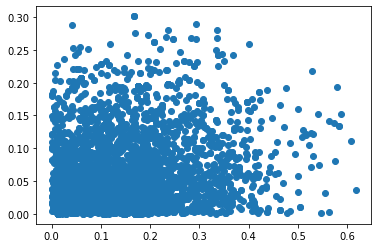

In [27]:
plt.plot(phi[:,6],phi[:,7],'o')